In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import GPy

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data

In [2]:
# load data
data = get_birth_data()
data

,year,month,day,births,day_of_year,day_of_week,date,ids,weekday,births_relative100,seasons
0,1969,1,1,8486,1,3,1969-01-01,1,1,87.947483,4
1,1969,1,2,9002,2,4,1969-01-02,2,1,93.295220,4
2,1969,1,3,9542,3,5,1969-01-03,3,1,98.891690,4
3,1969,1,4,8960,4,6,1969-01-04,4,0,92.859939,4
4,1969,1,5,8390,5,7,1969-01-05,5,0,86.952555,4
...,...,...,...,...,...,...,...,...,...,...,...
7300,1988,12,27,11528,362,2,1988-12-27,7301,1,119.474261,4
7301,1988,12,28,11847,363,3,1988-12-28,7302,1,122.780324,4
7302,1988,12,29,11704,364,4,1988-12-29,7303,1,121.298296,4
7303,1988,12,30,11837,365,5,1988-12-30,7304,1,122.676686,4


### Using GPy we experiment fitting GPRegression models

In [12]:
# Plotting GPs

def plot_fit(x,y,mu,var, pos=None, labels=None, l='predicted', legend=True, title='', line_color='C0'):
    """
    Plot the fit of a GP (adapted from https://adamian.github.io/talks/Damianou_GP_tutorial.html)
    """

    if y is not None:
        plt.figure(figsize=(15,5))
        plt.plot(x,y, '.', label='true data', c='black', markersize=1.5)

    plt.plot(x,mu, '-', label=l, c=line_color, linewidth=2)

    vv = 1.96 * np.sqrt(var) #+ sigma_n ** 2
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')

    if legend:
        plt.legend()
    if title != '':
        plt.title(title)
    if pos is not None:
        plt.xticks(pos, labels)

Text(0.5, 1.0, 'Births (centered) per year')

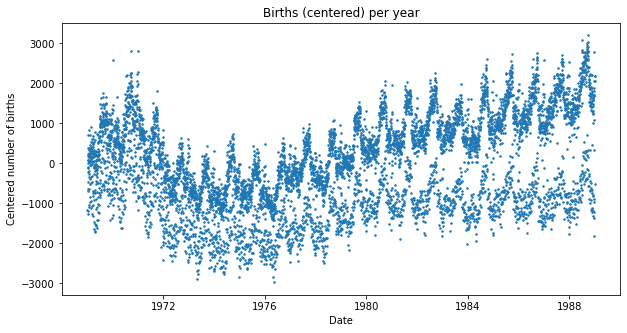

In [19]:
# prepare data
x = data.ids
x = np.reshape(x.to_numpy(), (7305,1))
y = data.births
y_c = y - np.mean(y)
y = np.reshape(y.to_numpy(), (7305,1))
y_c = np.reshape(y_c.to_numpy(), (7305,1))

# plot centered data
plt.figure(figsize=(10,5))
plt.plot(data.date, y_c, '.', markersize=3)
plt.xlabel('Date')
plt.ylabel('Centered number of births')
plt.title('Births (centered) per year')

#### RBF & optimize_restarts(5) & unobserved data predictions

optimizer = l-bfgs-b

In [35]:
### GPy - first fitting
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
gp1 = GPy.models.GPRegression(x, y, kernel)

gp1.optimize(messages=True)
print('restarts...')
gp1.optimize_restarts(num_restarts = 5)

 /Users/criss/miniforge3/envs/gp2/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/criss/miniforge3/envs/gp2/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/criss/miniforge3/envs/gp2/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


restarts...


 /Users/criss/miniforge3/envs/gp2/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 60219.414730000775
Optimization restart 2/5, f = 114006.03299610506
Optimization restart 3/5, f = 121819.96507924078
Optimization restart 4/5, f = 72931.53069134432
Optimization restart 5/5, f = 123470.86875786546


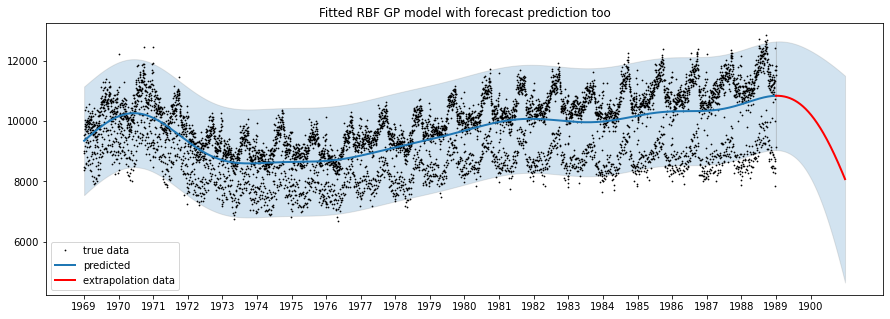

In [41]:
# for xlabels (xticks)
idss = []; yrs = []
yr = 1969
for i in range(20):
    df = data.loc[data.year == yr+i]
    yrs.append(yr+i)
    idss.append(df.index[0])

# predict and plot && predict on unobserved data (future predictions)
y_gp1, y_gp1_std = gp1.predict(x)
x_pred = np.arange(7306, 7306+(2*365)).reshape((2*365,1))
y_gp1_pred, y_gp1_std_pred = gp1.predict(x_pred)

plot_fit(x, y, y_gp1, y_gp1_std, l='predicted')
plot_fit(x_pred, None, y_gp1_pred, y_gp1_std_pred, pos=idss+[7306, 7306+365], labels=yrs+[1989,1900], l='extrapolation data', line_color='red', title='Fitted RBF GP model with forecast prediction too')

In [48]:
# get optimized parameters
from IPython.display import display
display(gp1)

GP_regression.,value,constraints,priors
rbf.variance,17484320.800921477,+ve,
rbf.lengthscale,893.1727737231815,+ve,
Gaussian_noise.variance,835443.0239317097,+ve,


#### RBF & no restarts & unobserved data prediction

optimizer = scg

In [ ]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
gp2 = GPy.models.GPRegression(x, y, k)
gp2.optimize(messages=True, optimizer='scg')

y_gp2, y_gp2_std = gp2.predict(x)
y_gp2_pred, y_gp2_std_pred = gp2.predict(x_pred)

plot_fit(x, y, y_gp2, y_gp2_std, l='predicted')
plot_fit(x_pred, None, y_gp2_pred, y_gp2_std_pred, pos=idss+[7306, 7306+365], labels=yrs+[1989,1900], l='extrapolation data', line_color='red', title='NO RESTARTS')

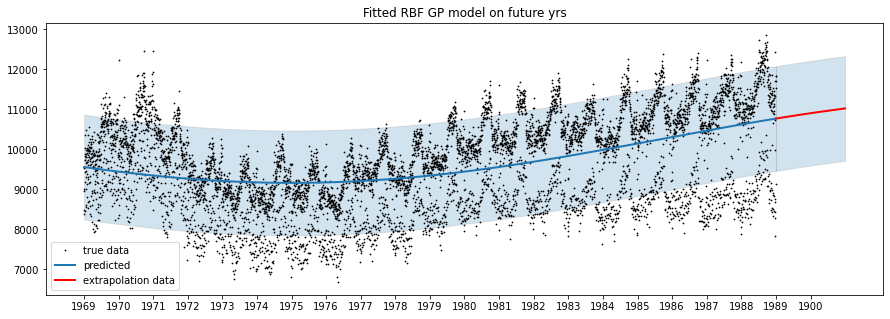

In [25]:
# rbk + periodic
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
k2 = GPy.kern.StdPeriodic(input_dim=1, variance=1., lengthscale=1.)
k = k1 + k2
gp2 = GPy.models.GPRegression(x, y, k)

gp2.optimize(messages=True, max_iters=45, optimizer='scg')

plot_fit(x, y, y_gp1, y_gp1_std, l='predicted')
plot_fit(x_pred, None, y_gp1_pred, y_gp1_std_pred, pos=idss+[7306, 7306+365], labels=yrs+[1989,1900], l='extrapolation data', line_color='red', title='Fitted RBF GP model on future yrs')

In [29]:
# make fitting and plotting more automatic

def fit_gp(x, y, k, idss, yrs, title=''):
    gp = GPy.models.GPRegression(x, y, k)
    gp.optimize(messages=True, optimizer='scg', max_iters=100)
    y_gp, y_gp_std = gp.predict(x)
    plot_fit(x, y, y_gp, y_gp_std, idss, yrs, title=title)

In [50]:
# Fit GP only on weekday data

data_weekdays = data.loc[data.weekday==1]

x_w = data_weekdays.ids
x_w = np.reshape(x_w.to_numpy(), (x_w.shape[0],1))
y_w = data_weekdays.births
y_wc = y_w - np.mean(y_w)
y_w = np.reshape(y_w.to_numpy(), (x_w.shape[0],1))
y_wc = np.reshape(y_wc.to_numpy(), (x_w.shape[0],1))

k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.) + GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)
# k2 = GPy.kern.StdPeriodic(input_dim=1, variance=1., lengthscale=1.)
# k = k1 + k2

# for xlabels
idss_w = []; yrs_w = []
yr = 1969
for i in range(20):
    df = data_weekdays.loc[data_weekdays.year == yr+i]
    yrs_w.append(yr+i)
    idss_w.append(df.index[0])

# fit and plot
fit_gp(x_w, y_w, k, idss_w, yrs_w, title='GP for weekdays data')

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
# Matern kernel

k = GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)
fit_gp(x, y, k, idss, yrs, title='GP Matern kernel') ### gives NAN - no convergence